# FEM Modelling for Three-Phase STEDIN Transformer

### Transient + Voltage fed Analysis

General FEM equation, 
\begin{equation}
    Au + B \frac{\partial u}{\partial t} = f
\end{equation}

Circuit equation,
\begin{equation}
    V = G'\frac{\partial u}{\partial t} + R_{ext}I + L_{ext} \frac{\partial I}{\partial t}
\end{equation}

Combining and writing in time-stepping format,
\begin{equation}
    \begin{bmatrix}
        \frac{B}{\Delta t} + A & -f \\
        \frac{G^T}{\Delta t} & R_{ext} + \frac{L_{ext}}{\Delta t}
    \end{bmatrix} \begin{bmatrix}
        u \\
        I
    \end{bmatrix}^{t+\Delta t} = \begin{bmatrix}
        \frac{B}{\Delta t} & 0 \\
        \frac{G^T}{\Delta t} & \frac{L_{ext}}{\Delta t}
    \end{bmatrix} \begin{bmatrix}
        u \\
        I
    \end{bmatrix}^{t} + \begin{bmatrix}
        0 \\
        V^{t+\Delta t}
    \end{bmatrix}
\end{equation}

Simplifying,
\begin{equation}
    \begin{bmatrix}
        B + \Delta t A & - \Delta t f \\
        G^T & \Delta t R_{ext} + L_{ext}
    \end{bmatrix} \begin{bmatrix}
        u \\
        I
    \end{bmatrix}^{t+\Delta t} = \begin{bmatrix}
        B & 0 \\
        G^T & L_{ext}
    \end{bmatrix} \begin{bmatrix}
        u \\
        I
    \end{bmatrix}^{t} + \begin{bmatrix}
        0 \\
        \Delta t V^{t+\Delta t}
    \end{bmatrix}
\end{equation}

## Import Packages

In [1]:
print(" ▸ Loading Packages .... \r")
start = time_ns()
using gmsh
using LinearAlgebra
using LaTeXStrings
using Plots
using CSV
using DataFrames
include("../../../../lib/Makie_Plots.jl");
using .Makie_Plots
include("../../../../lib/FEM_Transient_VoltageFed_Tri_1e.jl");
using .FEM_Transient_VoltageFed_Tri_1e
include("../../../../lib/Post_Process_Time.jl");
using .Post_Process_Time
include("../../../../lib/Mesh_Data_stedin.jl");
using .Mesh_Data_stedin
include("../../../../lib/Save_VTK.jl");
using .Save_VTK
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Packages loaded ("*string(elapsed)*" seconds)                               ")

 ✓ Packages loaded (26.98 seconds)                               


## Julia code

In [2]:
gmsh.initialize()

## Read mesh from file
print(" ▸ Reading mesh file .... \r")
start = time_ns()
gmsh.open("../../../../Geometry/mesh/stedin_transformer.msh")
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Mesh file loaded ("*string(elapsed)*" seconds)                               ")

print(" ▸ Generating required mesh data .... \r")
start = time_ns()
mesh_data = get_mesh_data_tri_1e(gmsh)
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Mesh data generated ("*string(elapsed)*" seconds)                               ")

print(" ▸ Setting initial parameters .... \r")
start = time_ns()
S = 400e3;                    # Power rating
Vp = 10750 * sqrt(2);         # Primary peak phase voltage
Vs = 420 * sqrt(2/3);         # Secondary peak phase voltage
Ip = (S/10750) * sqrt(2/9);   # Primary peak phase current
Is = (S/420) * sqrt(2/3);     # Secondary peak phase current
Np = 266;                     # Primary turns
Ns = 6;                       # Secondary turns

# External resistance Rext
Rp = 1.8131 + 600
Rs = 1.2999e-3 + 0.2
CFFp = 0.3
CFFs = 0.3

# External Inductance Lext
Lext = 1e-6

# Z-axis length
z_len_p = 0.4
z_len_s = 0.4

omega = 2*pi*50;  # Frequency

# HV winding dimensions (all phases left/right are identical)
wwhv = 3e-2;
hwhv = 74e-2;
mwhv = 14.75e-2;
Awhv = wwhv * hwhv;

# LV winding dimensions (all phases left/right are identical)
wwlv = 2e-2;
hwlv = 74e-2;
mwlv = 11.25e-2;
Awlv = wwlv * hwlv;

# Calculate turn density in the windings
Tp = Np / Awhv;
Ts = Ns / Awlv;

# Relative permeability model
mu0 = 4e-7 * pi;
mur = 2500;       # Relative permeability of the core
reluctivityfunction(group_id) = (1 / mu0) + (1/(mu0*mur) - 1/mu0) * (group_id == 2)
reluctivityperelementts = map(reluctivityfunction, mesh_data.e_group);

# Conductivity
conductivityfunction(group_id) = 0;
conductivityperelement = map(conductivityfunction, mesh_data.e_group);

# Handle the boundary conditions
bnd_node_ids, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1);

# Specify time start, end and step
init_time = 0
n_cycles = 5
final_time = n_cycles*(2*pi/omega)
dt = (final_time-init_time) / (60*n_cycles)
time_steps = Vector(init_time:dt:final_time)

reluctivityperelement = Vector{Array{Float64,1}}(undef, length(time_steps))
for k = 1:length(time_steps)
    reluctivityperelement[k] = reluctivityperelementts
end

elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Initial parameters set ("*string(elapsed)*" seconds)                               ")

Info    : Reading '../../../../Geometry/mesh/stedin_transformer.msh'...
Info    : 168 entities
Info    : 10385 nodes
Info    : 20768 elements
Info    : Done reading '../../../../Geometry/mesh/stedin_transformer.msh'
 ✓ Mesh file loaded (0.06 seconds)                               
 ✓ Mesh data generated (4.47 seconds)                               
 ✓ Initial parameters set (0.18 seconds)                               


### Open Circuit Test (Core Loss)

In [3]:
print(" ▸ Setting initial parameters .... \r")
start = time_ns()
# Z-axis length
z_length = [z_len_s; z_len_s; z_len_s];

# Source turn density T
# One term for each of the windings, with a positive and negative part
sourcefunction(group_id) = [Ts*(-1*(group_id==9) + 1*(group_id==10)),
                            Ts*(-1*(group_id==11) + 1*(group_id==12)),
                            Ts*(-1*(group_id==13) + 1*(group_id==14))];
sourceperelement = map(sourcefunction, mesh_data.e_group);

# Source voltage V
# One term for each of the windings, with a positive and negative part
coil_voltage = [Vs*exp(1im*-2pi/3); Vs; Vs*exp(1im*2pi/3)];

# External resistance Rext
# One term for each of the windings, with a positive and negative part
ext_resistance = [Rs/CFFs; Rs/CFFs; Rs/CFFs];

# External inductance Lext
# One term for each of the windings, with a positive and negative part
ext_inductance = Lext .* [1; 1; 1];
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Initial parameters set ("*string(elapsed)*" seconds)                               ")

# Calculate the vector potential
u = fem_nonlinear(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, coil_voltage, ext_resistance, ext_inductance, z_length, time_steps);

# Post-process for magnetic field and current density
Bx, By, B, Hx, Hy, H, mag_energy = post_process(mesh_data, u, reluctivityperelement, time_steps);

# Calculate source current density
Jel = source_current_density(mesh_data, u, sourceperelement, time_steps);

# Calculate core loss
Pv, Pcore = core_loss(mesh_data, B, z_length, time_steps);

 ✓ Initial parameters set (0.19 seconds)                               
 ✓ Matrices constructed (0.07 seconds)                               
 ✓ Solution computed (2788.33 seconds)                               
 ✓ Post processing variables computed (1.93 seconds)                               
 ✓ Current density computed (17.02 seconds)                               
 ✓ Core loss computed (0.25 seconds)                               


#### Plots

In [4]:
selected_node = 4276
selected_element = 7051
u_wave = [u_curr[selected_node] for u_curr in u];
V1_wave = zeros(length(time_steps),1)
for k = 1:length(time_steps)
    V1_wave[k] = imag(coil_voltage[1].*exp(1im*omega*time_steps[k]))
end
I1_wave = [u_curr[mesh_data.nnodes+1] for u_curr in u];
Bx_wave = [Bx_curr[selected_element] for Bx_curr in Bx];
By_wave = [By_curr[selected_element] for By_curr in By];
B_wave = [B_curr[selected_element] for B_curr in B];
Hx_wave = [Hx_curr[selected_element] for Hx_curr in Hx];
Hy_wave = [Hy_curr[selected_element] for Hy_curr in Hy];
H_wave = [H_curr[selected_element] for H_curr in H];
mag_energy_wave = [mag_energy_curr[selected_element] for mag_energy_curr in mag_energy];
reluctivityperelement_wave = [reluctivityperelement_curr[selected_element] for reluctivityperelement_curr in reluctivityperelement];
Pv_wave = [Pv_curr[selected_element] for Pv_curr in Pv];

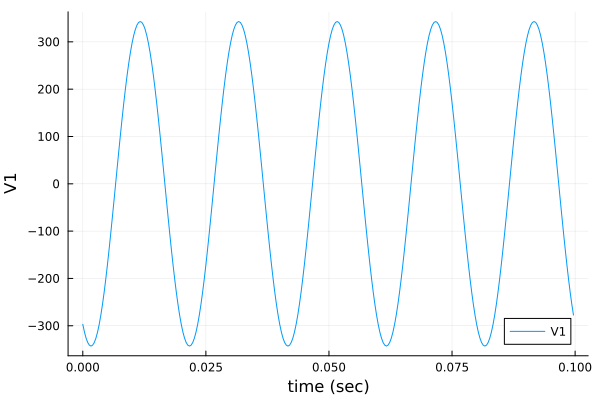

In [5]:
plot(time_steps, V1_wave, label = "V1")
xlabel!("time (sec)")
ylabel!("V1")

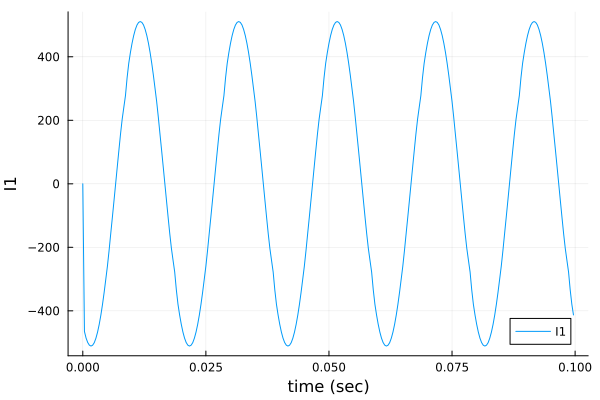

In [6]:
plot(time_steps, I1_wave, label = "I1")
xlabel!("time (sec)")
ylabel!("I1")

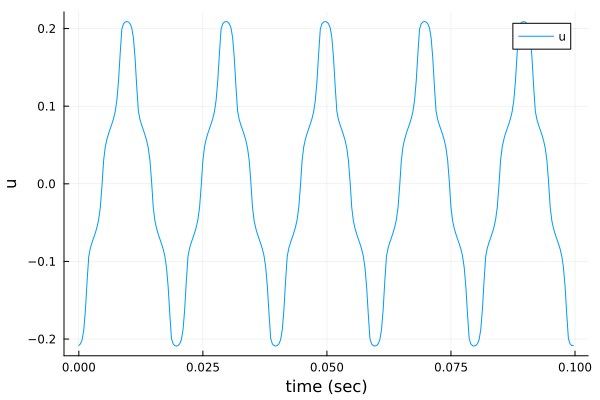

In [7]:
plot(time_steps, u_wave, label = "u")
xlabel!("time (sec)")
ylabel!("u")

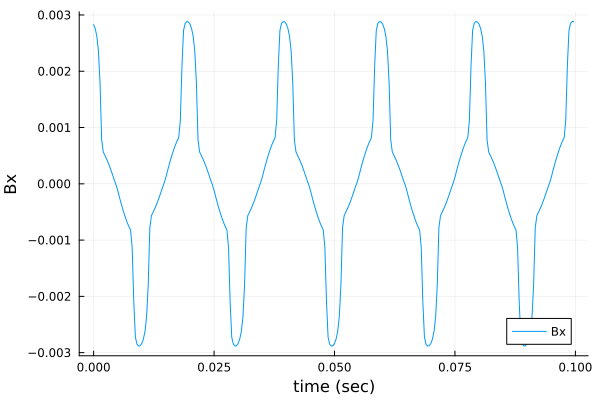

In [8]:
plot(time_steps, Bx_wave, label = "Bx")
xlabel!("time (sec)")
ylabel!("Bx")

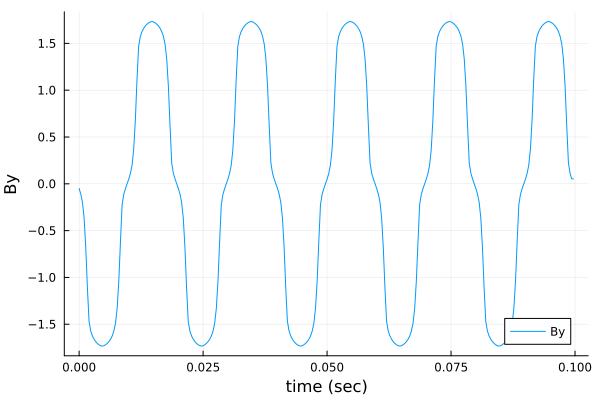

In [9]:
plot(time_steps, By_wave, label = "By")
xlabel!("time (sec)")
ylabel!("By")

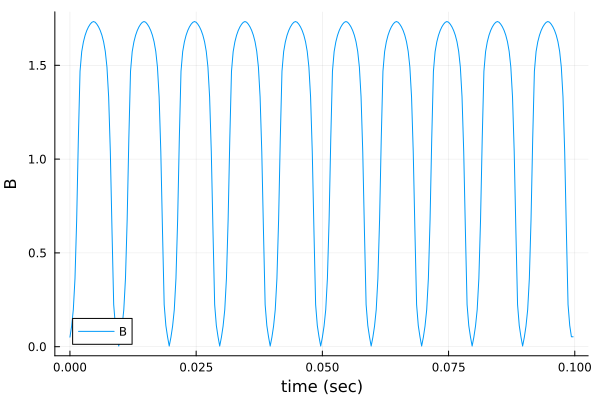

In [10]:
plot(time_steps, B_wave, label = "B")
xlabel!("time (sec)")
ylabel!("B")

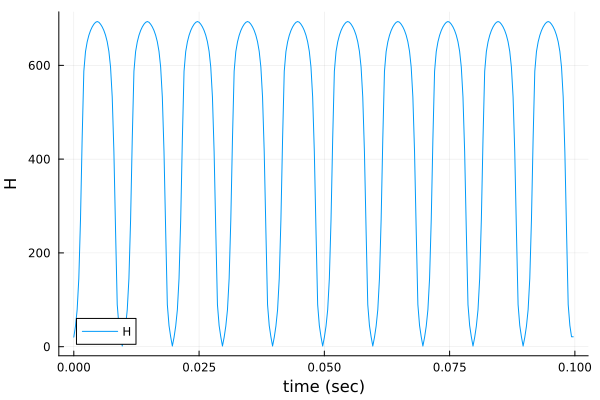

In [11]:
plot(time_steps, H_wave, label = "H")
xlabel!("time (sec)")
ylabel!("H")

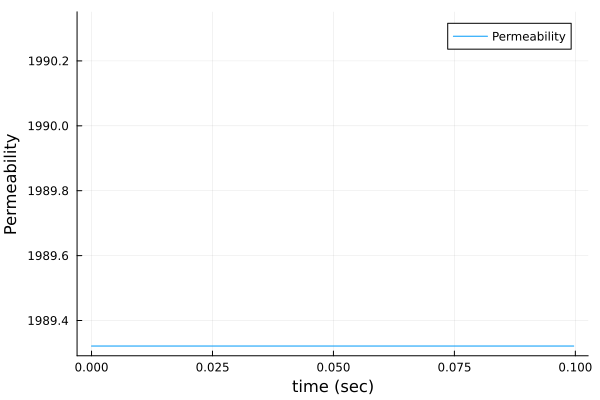

In [12]:
plot(time_steps, 1 ./ reluctivityperelement_wave ./ mu0, label = "Permeability")
xlabel!("time (sec)")
ylabel!("Permeability")

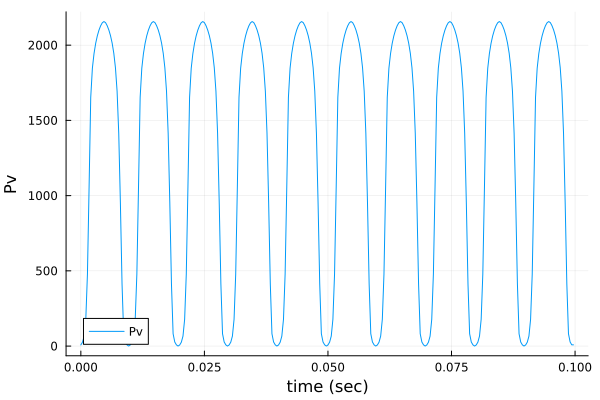

In [13]:
plot(time_steps, Pv_wave, label = "Pv")
xlabel!("time (sec)")
ylabel!("Pv")

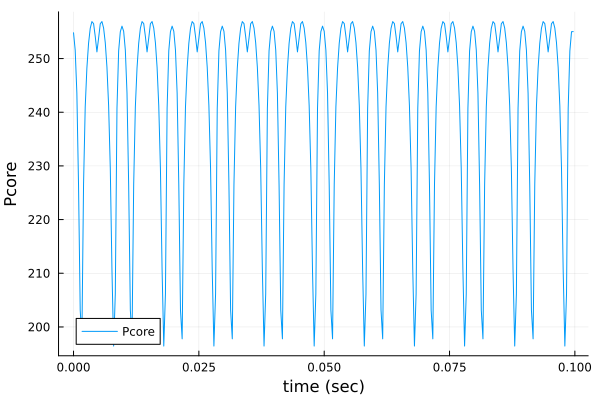

In [14]:
plot(time_steps, Pcore, label = "Pcore")
xlabel!("time (sec)")
ylabel!("Pcore")

In [15]:
print(" ▸ Saving CSV files .... \r")
start = time_ns()
Bx_mat = DataFrame(hcat(Bx...), :auto)
CSV.write("../csv/stedin_trafo_Bx_voltagefed_nonlin_OC.csv", Bx_mat)
By_mat = DataFrame(hcat(By...), :auto)
CSV.write("../csv/stedin_trafo_By_voltagefed_nonlin_OC.csv", By_mat)
B_mat = DataFrame(hcat(B...), :auto)
CSV.write("../csv/stedin_trafo_B_voltagefed_nonlin_OC.csv", B_mat)
Hx_mat = DataFrame(hcat(Hx...), :auto)
CSV.write("../csv/stedin_trafo_Hx_voltagefed_nonlin_OC.csv", Hx_mat)
Hy_mat = DataFrame(hcat(Hy...), :auto)
CSV.write("../csv/stedin_trafo_Hy_voltagefed_nonlin_OC.csv", Hy_mat)
H_mat = DataFrame(hcat(H...), :auto)
CSV.write("../csv/stedin_trafo_H_voltagefed_nonlin_OC.csv", H_mat)
mag_energy_mat = DataFrame(hcat(mag_energy...), :auto)
CSV.write("../csv/stedin_trafo_mag_energy_voltagefed_nonlin_OC.csv", mag_energy_mat)
permabilityperelement = Vector{Array{Float64,1}}(undef, length(time_steps))
for k = 1:length(time_steps)
    permabilityperelement[k] = reluctivityperelement[k]
end
permability_mat = DataFrame(hcat(permabilityperelement...), :auto)
CSV.write("../csv/stedin_trafo_mu_voltagefed_nonlin_OC.csv", permability_mat)
Pv_mat = DataFrame(hcat(Pv...), :auto)
CSV.write("../csv/stedin_trafo_Pv_voltagefed_nonlin_OC.csv", Pv_mat)
Pcore_mat = DataFrame(hcat(Pcore...), :auto)
CSV.write("../csv/stedin_trafo_Pcore_voltagefed_nonlin_OC.csv", Pcore_mat)
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ CSV files saved ("*string(elapsed)*" seconds)                               ")

 ✓ CSV files saved (14.9 seconds)                               


### Short Circuit Test (Winding Losses)

In [16]:
print(" ▸ Setting initial parameters .... \r")
start = time_ns()
# Z-axis length
z_length = [z_len_p; z_len_p; z_len_p;
            z_len_s; z_len_s; z_len_s];

# Source turn density T
# One term for each of the windings, with a positive and negative part
sourcefunction(group_id) = [Tp*(1*(group_id==3) - 1*(group_id==4)),
                            Tp*(1*(group_id==5) - 1*(group_id==6)),
                            Tp*(1*(group_id==7) - 1*(group_id==8)),
                            Ts*(-1*(group_id==9) + 1*(group_id==10)),
                            Ts*(-1*(group_id==11) + 1*(group_id==12)),
                            Ts*(-1*(group_id==13) + 1*(group_id==14))];
sourceperelement = map(sourcefunction, mesh_data.e_group);

# Source voltage V
# One term for each of the windings, with a positive and negative part
coil_voltage = [Vp*exp(1im*-2pi/3); Vp; Vp*exp(1im*2pi/3);
                0; 0; 0];

# External resistance Rext
# One term for each of the windings, with a positive and negative part
ext_resistance = [Rp/CFFp; Rp/CFFp; Rp/CFFp; 
                  Rs/CFFs; Rs/CFFs; Rs/CFFs];
    
# External resistance Rext
# One term for each of the windings, with a positive and negative part
ext_inductance = Lext .* [1; 1; 1; 
                          1; 1; 1];

elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Initial parameters set ("*string(elapsed)*" seconds)                               ")

# Calculate the vector potential
u = fem_nonlinear(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, coil_voltage, ext_resistance, ext_inductance, z_length, time_steps);

# Post-process for magnetic field and current density
Bx, By, B, Hx, Hy, H, mag_energy = post_process(mesh_data, u, reluctivityperelement, time_steps);

# Calculate source current density
Jel = source_current_density(mesh_data, u, sourceperelement, time_steps);

ext_resistance = [Rp; Rp; Rp; 
                  Rs; Rs; Rs];
# Calculate winding loss
Pwindingp, Pwindings = winding_loss(mesh_data, u, ext_resistance, time_steps);

 ✓ Initial parameters set (0.21 seconds)                               
 ✓ Matrices constructed (0.03 seconds)                               
 ✓ Solution computed (3794.23 seconds)                               
 ✓ Post processing variables computed (1.23 seconds)                               
 ✓ Current density computed (15.38 seconds)                               
 ✓ Winding loss computed (0.25 seconds)                               


#### Plots

In [17]:
selected_node = 4276
selected_element = 7051
u_wave = [u_curr[selected_node] for u_curr in u];
V1_wave = zeros(length(time_steps),1)
for k = 1:length(time_steps)
    V1_wave[k] = imag(coil_voltage[1].*exp(1im*omega*time_steps[k]))
end
I1_wave = [u_curr[mesh_data.nnodes+1] for u_curr in u];
Bx_wave = [Bx_curr[selected_element] for Bx_curr in Bx];
By_wave = [By_curr[selected_element] for By_curr in By];
B_wave = [B_curr[selected_element] for B_curr in B];
Hx_wave = [Hx_curr[selected_element] for Hx_curr in Hx];
Hy_wave = [Hy_curr[selected_element] for Hy_curr in Hy];
H_wave = [H_curr[selected_element] for H_curr in H];
mag_energy_wave = [mag_energy_curr[selected_element] for mag_energy_curr in mag_energy];
reluctivityperelement_wave = [reluctivityperelement_curr[selected_element] for reluctivityperelement_curr in reluctivityperelement];

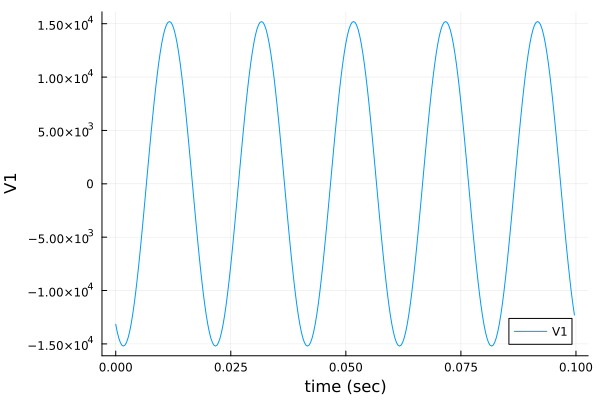

In [18]:
plot(time_steps, V1_wave, label = "V1")
xlabel!("time (sec)")
ylabel!("V1")

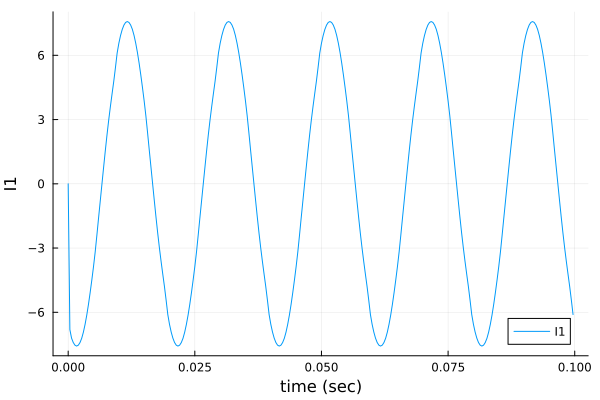

In [19]:
plot(time_steps, I1_wave, label = "I1")
xlabel!("time (sec)")
ylabel!("I1")

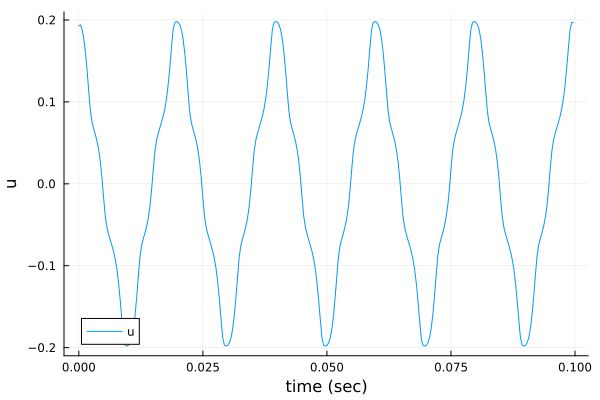

In [20]:
plot(time_steps, u_wave, label = "u")
xlabel!("time (sec)")
ylabel!("u")

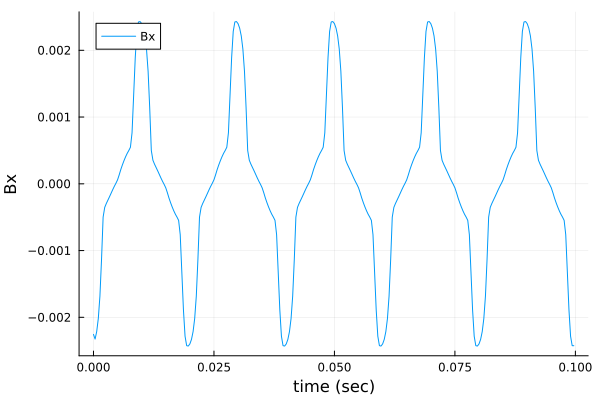

In [21]:
plot(time_steps, Bx_wave, label = "Bx")
xlabel!("time (sec)")
ylabel!("Bx")

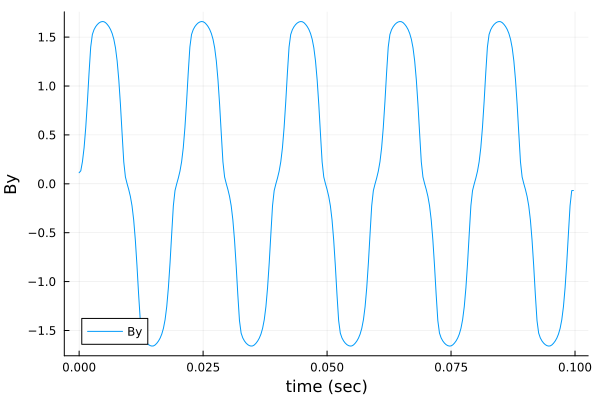

In [22]:
plot(time_steps, By_wave, label = "By")
xlabel!("time (sec)")
ylabel!("By")

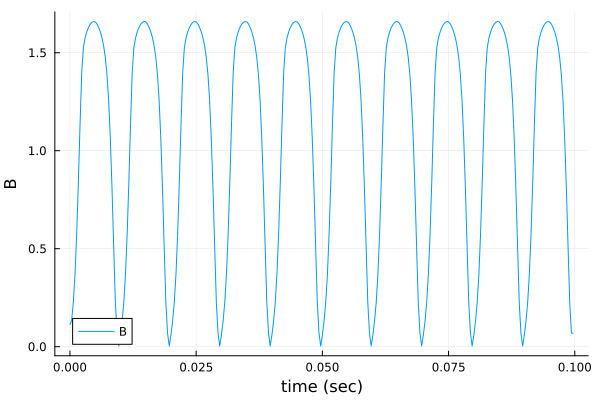

In [23]:
plot(time_steps, B_wave, label = "B")
xlabel!("time (sec)")
ylabel!("B")

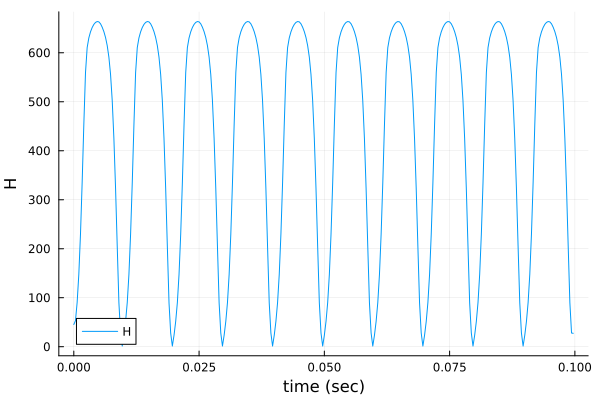

In [24]:
plot(time_steps, H_wave, label = "H")
xlabel!("time (sec)")
ylabel!("H")

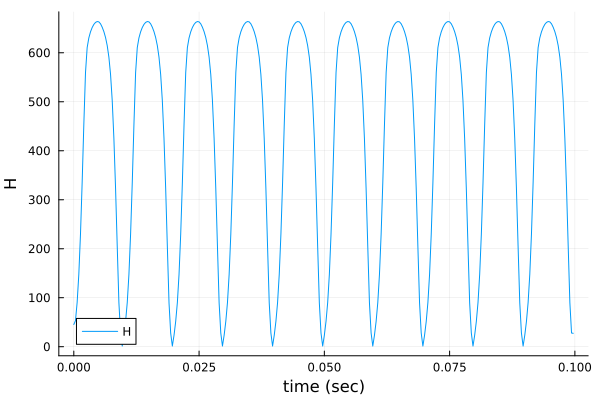

In [25]:
plot(time_steps, H_wave, label = "H")
xlabel!("time (sec)")
ylabel!("H")

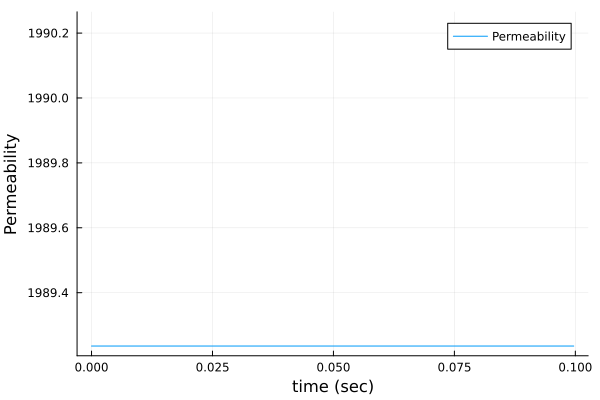

In [26]:
plot(time_steps, 1 ./ reluctivityperelement_wave ./ mu0, label = "Permeability")
xlabel!("time (sec)")
ylabel!("Permeability")

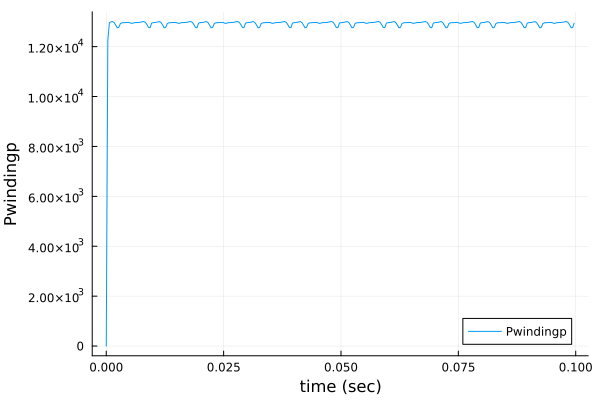

In [27]:
plot(time_steps, Pwindingp, label = "Pwindingp")
xlabel!("time (sec)")
ylabel!("Pwindingp")

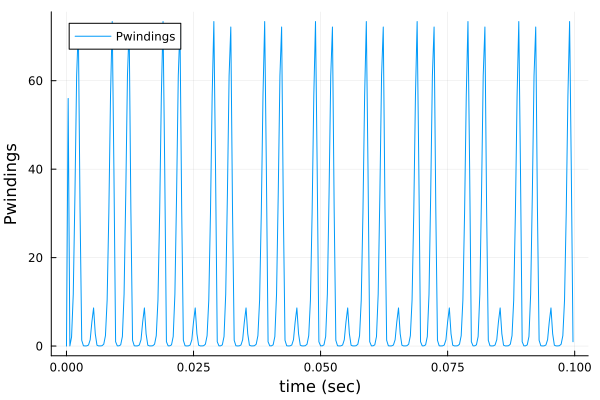

In [28]:
plot(time_steps, Pwindings, label = "Pwindings")
xlabel!("time (sec)")
ylabel!("Pwindings")

In [29]:
print(" ▸ Saving CSV files .... \r")
start = time_ns()
Bx_mat = DataFrame(hcat(Bx...), :auto)
CSV.write("../csv/stedin_trafo_Bx_voltagefed_nonlin_SC.csv", Bx_mat)
By_mat = DataFrame(hcat(By...), :auto)
CSV.write("../csv/stedin_trafo_By_voltagefed_nonlin_SC.csv", By_mat)
B_mat = DataFrame(hcat(B...), :auto)
CSV.write("../csv/stedin_trafo_B_voltagefed_nonlin_SC.csv", B_mat)
Hx_mat = DataFrame(hcat(Hx...), :auto)
CSV.write("../csv/stedin_trafo_Hx_voltagefed_nonlin_SC.csv", Hx_mat)
Hy_mat = DataFrame(hcat(Hy...), :auto)
CSV.write("../csv/stedin_trafo_Hy_voltagefed_nonlin_SC.csv", Hy_mat)
H_mat = DataFrame(hcat(H...), :auto)
CSV.write("../csv/stedin_trafo_H_voltagefed_nonlin_SC.csv", H_mat)
mag_energy_mat = DataFrame(hcat(mag_energy...), :auto)
CSV.write("../csv/stedin_trafo_mag_energy_voltagefed_nonlin_SC.csv", mag_energy_mat)
permabilityperelement = Vector{Array{Float64,1}}(undef, length(time_steps))
for k = 1:length(time_steps)
    permabilityperelement[k] = 1 ./ mu0 ./ reluctivityperelement[k]
end
permability_mat = DataFrame(hcat(permabilityperelement...), :auto)
CSV.write("../csv/stedin_trafo_mu_voltagefed_nonlin_SC.csv", permability_mat)
Pwindingp_mat = DataFrame(hcat(Pwindingp...), :auto)
CSV.write("../csv/stedin_trafo_Pwindingp_voltagefed_nonlin_SC.csv", Pwindingp_mat)
Pwindings_mat = DataFrame(hcat(Pwindings...), :auto)
CSV.write("../csv/stedin_trafo_Pwindings_voltagefed_nonlin_SC.csv", Pwindings_mat)
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ CSV files saved ("*string(elapsed)*" seconds)                               ")

 ✓ CSV files saved (9.2 seconds)                               
